## Bias correction testing ##

Now that we have established that there are biases in the HadGEM3-GC31-MM ensemble when compared to ERA5 on monthly timescales, for temperature, solar irradiance, and 10m wind speeds, we can now go about testing the bias correction which is applied to the daily data. Utilizing methods from Dawkins et al. (2021) and Luo et al., (2018).

* Dawkins et al. (2021) - https://catalogue.ceda.ac.uk/uuid/7beeed0bc7fa41feb10be22ee9d10f00?jump=related-docs-anchor

* Luo et al. (2018) - https://www.mdpi.com/2073-4441/10/8/1046

In [1]:
import os
import sys
import glob
import importlib
from tqdm import tqdm

# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# # Optional dask stuff
# import dask_gateway
# import pathlib

In [2]:
# Import the functsions
sys.path.append("/home/users/benhutch/unseen_functions/")

# import the bias functions
import bias_functions as bf

In [3]:
# import the dictionaries
sys.path.append("/home/users/benhutch/unseen_functions/")

# import the dictionaries
import unseen_dictionaries as udicts

In [4]:
# Set up the arguments
# --------------------
model = "HadGEM3-GC31-MM"
variable = "psl"
obs_variable = "msl"
lead_time = 1 # first start november to end october period
experiment = "dcppA-hindcast"
freq = "day"
engine = "netcdf4"
parallel = False

# Init years for testing
init_years = [1960]

# Test file for daily data
test_file = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/day/psl/gn/files/d20200417/psl_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_19601101-19601230.nc"

# Daily obs fpath - single var - t2m
obs_fpath = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_msl_daily_1960_2020_daymean.nc"

In [5]:
%%time

# Load the dcpp daily data
ds = bf.load_dcpp_data_lead(
    model=model,
    variable=variable,
    lead_time=lead_time,
    init_years=init_years,
    experiment=experiment,
    frequency=freq,
    engine=engine,
    parallel=parallel,
)

Model path: /badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast
Model path root: badc
Loading data from BADC
Unique variants: ['r7i1p1f2', 'r8i1p1f2', 'r1i1p1f2', 'r9i1p1f2', 'r4i1p1f2', 'r2i1p1f2', 'r10i1p1f2', 'r5i1p1f2', 'r3i1p1f2', 'r6i1p1f2']
Shape of agg_files: 120


Loading data:   0%|          | 0/1 [00:00<?, ?it/s]

Loading data: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]

Converting the lead times to days assuming datetime360 day frequency.
First date: 1960-11-01 00:00:00
Last date: 1971-03-30 00:00:00
bounds: time_bnds
units: days since 1850-01-01
calendar: 360_day
axis: T
long_name: time
standard_name: time
First value of time: 39900.5
Lead time is 1
First day: 1960-11-01 00:00:00
Last day: 1961-10-30 00:00:00
ds: <xarray.Dataset>
Dimensions:    (lead: 360, init: 1, member: 10, bnds: 2, lat: 324, lon: 432)
Coordinates:
  * lead       (lead) int64 2 3 4 5 6 7 8 9 ... 354 355 356 357 358 359 360 361
  * lat        (lat) float64 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon        (lon) float64 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.7 359.6
Dimensions without coordinates: init, member, bnds
Data variables:
    time_bnds  (init, member, lead, bnds) object dask.array<chunksize=(1, 1, 9, 2), meta=np.ndarray>
    lat_bnds   (init, member, lat, bnds) float64 dask.array<chunksize=(1, 1, 324, 2), meta=np.ndarray>
    lon_bnds   (init, member, l

In [6]:
%%time

# Regrid the data
ds = bf.regrid_ds(
    ds=ds,
    variable=variable,
)

Lat res: <xarray.DataArray 'lat' ()>
array(0.5555556)
Lon res: <xarray.DataArray 'lon' ()>
array(0.83333329)
CPU times: user 6.1 s, sys: 313 ms, total: 6.41 s
Wall time: 6.73 s


In [7]:
%%time

# Select the gridbox
ds = bf.select_gridbox(
    ds=ds,
    grid=udicts.eu_grid,
    calc_mean=False,
)

CPU times: user 5.32 ms, sys: 0 ns, total: 5.32 ms
Wall time: 4.68 ms


In [8]:
%%time

# Load th test file
test_ds = xr.open_dataset(test_file)

# Load the daily observations
obs = bf.load_and_rg_obs(
    model_ds=test_ds,
    obs_variable="msl",
    obs_path=obs_fpath,
    init_years=init_years,
    lead_time=lead_time,
    rg_algo="bilinear",
    grid_bounds=[-180.0, 180.0, -90.0, 90.0],
    periodic=True,
    parallel=False,
)

CPU times: user 3.29 s, sys: 38.4 ms, total: 3.33 s
Wall time: 3.52 s


In [9]:
# select the gridbox for the obs
obs = bf.select_gridbox(
    ds=obs,
    grid=udicts.eu_grid,
    calc_mean=False,
)

In [10]:
obs.values.mean()

nan

In [11]:
ds.values.mean()

nan

In [14]:
# reload the functions
importlib.reload(bf)

<module 'bias_functions' from '/home/users/benhutch/unseen_functions/bias_functions.py'>

In [15]:
%%time

# test the calculate and save bias coeffs function
bc_data = bf.calc_and_save_bias_coeffs(
    model_ds=ds,
    obs_ds=obs,
    lead_time=lead_time,
    month=11, # test with the first month for now
    init_years=init_years,
    variable=variable,
    model_name=model,
    save_flag=True,
)


Leads to select: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Obs month: <xarray.DataArray (time: 30, y: 324, x: 432)>
dask.array<getitem, shape=(30, 324, 432), dtype=float32, chunksize=(10, 324, 432), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1960-11-01T11:00:00 ... 1960-11-30T11:00:00
    lon      (x) float64 -179.6 -178.8 -177.9 -177.1 ... 177.1 177.9 178.7 179.6
    lat      (y) float64 -89.72 -89.17 -88.61 -88.06 ... 88.06 88.61 89.17 89.72
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear
Model month: <xarray.DataArray (init: 1, member: 10, lead: 30, y: 324, x: 432)>
dask.array<getitem, shape=(1, 10, 30, 324, 432), dtype=float32, chunksize=(1, 1, 10, 324, 432), chunktype=numpy.ndarray>
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * member   (member) <U9 'r7i1p1f2' 'r8i1p1f2' ... 'r3i1p1f2' 'r6i1p1f2'
  * init     (init) int6

Calculating bias coefficients lon: 432it [00:03, 119.86it/s]

Shape of bc_model_data_month: (1, 10, 30, 324, 432)
BC Model Data Month: [[[[[nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    ...
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]]

   [[nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    ...
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]]

   [[nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    ...
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]]

   ...

   [[nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    ...
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan nan]]

   [[nan nan nan ... nan nan nan]
    [nan nan nan ... nan nan 

#### Verifying bias correction ####

Now that we have applied this simple bias correction for a given model, variable, lead time and month, we want to check whether it has actually done anything. We can do this by comparing the spatial fields for the model - obs for the mean and standard deviation.

In [19]:
importlib.reload(bf)

<module 'bias_functions' from '/home/users/benhutch/unseen_functions/bias_functions.py'>

Leads to select: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Obs month: <xarray.DataArray (time: 30, y: 324, x: 432)>
dask.array<getitem, shape=(30, 324, 432), dtype=float32, chunksize=(10, 324, 432), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1960-11-01T11:00:00 ... 1960-11-30T11:00:00
    lon      (x) float64 -179.6 -178.8 -177.9 -177.1 ... 177.1 177.9 178.7 179.6
    lat      (y) float64 -89.72 -89.17 -88.61 -88.06 ... 88.06 88.61 89.17 89.72
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear
Model month: <xarray.DataArray (init: 1, member: 10, lead: 30, y: 324, x: 432)>
dask.array<getitem, shape=(1, 10, 30, 324, 432), dtype=float32, chunksize=(1, 1, 10, 324, 432), chunktype=numpy.ndarray>
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
  * member   (member) <U9 'r1i1p1f2' 'r7i1p1f2' ... 'r4i1p1f2' 'r3i1p1f2'
  * init     (init) int6

/home/users/benhutch/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Shape of bias: (324, 432)
Shape of bc_bias: (324, 432)
Min bias: nan, Max bias: nan
Min bc_bias: nan, Max bc_bias: nan


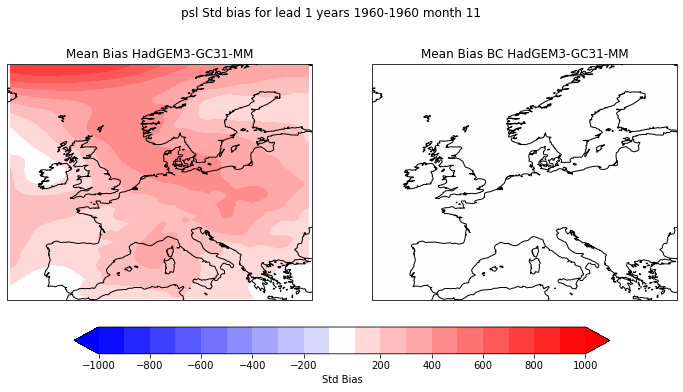

In [20]:
bf.verify_bc_plot(
    model_ds=ds,
    obs_ds=obs,
    bc_model_data=bc_data,
    lead_time=lead_time,
    month=11,
    init_years=init_years,
    variable="psl",
    model_name=model,
    mean_or_std="std",
    std_clevs=(-1000, 1100, 100),
    std_ticks=(-1000, 1100, 200),
)